# From PDF to Video with Azure AI

## Transform a PDF document into a narrated video using Azure AI services:

- PDF to image conversion
- Image summarization with gpt-4.1
- Text-to-speech synthesis
- Video generation per slide
- Final video compilation

<img src="logo.png" width=360>

In [1]:
import azure.cognitiveservices.speech as speechsdk
import base64
import datetime
import fitz
import glob
import io
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import time

from dotenv import load_dotenv
from io import BytesIO
from IPython.display import FileLink, Video
from openai import AzureOpenAI
from mimetypes import guess_type
from moviepy import clips_array, ImageClip, AudioFileClip, CompositeAudioClip, VideoFileClip, concatenate_videoclips
from PIL import Image

## 1. Settings

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 22-Jul-2025 15:32:52


In [4]:
IMAGES_DIR = "results/images"

os.makedirs(IMAGES_DIR, exist_ok=True)

In [5]:
AUDIO_DIR = "results/audio"

os.makedirs(AUDIO_DIR, exist_ok=True)

In [6]:
VIDEO_DIR = "results/video"

os.makedirs(VIDEO_DIR, exist_ok=True)

In [7]:
FINAL_VIDEO_DIR = "video"

os.makedirs(FINAL_VIDEO_DIR, exist_ok=True)

In [8]:
load_dotenv("azure.env")

# Model
endpoint = os.getenv("endpoint")
key = os.getenv("key")
api_version = "2025-01-01-preview"
model = "gpt-4.1"

# Azure Speech for Text to Speech
speech_key = os.getenv("speech_key")
service_region = os.getenv("service_region")

## 2. Helper

In [9]:
def from_pdf_to_images(pdf_document, image_format="PNG", dpi=150):
    """
    Convert each page of a PDF to individual image files.
    
    Args:
        pdf_document (str): Path to the PDF file
        output_folder (str): Folder to save the images
        image_format (str): Image format (PNG, JPEG, etc.)
        dpi (int): Resolution for the images
    """
    file = os.path.splitext(os.path.basename(pdf_document))[0].lower().replace(
        " ", "_")

    # Open the PDF
    pdf_document = fitz.open(pdf_document)
    print(f"Processing {len(pdf_document)} pages from document: {pdf_document}\n")

    for page_num in range(len(pdf_document)):
        # Get the page
        page = pdf_document[page_num]
        # Create a matrix for the resolution
        mat = fitz.Matrix(dpi / 72, dpi / 72)  # 72 is the default DPI
        # Render page to an image
        pix = page.get_pixmap(matrix=mat)
        # Convert to PIL Image
        img_data = pix.tobytes("png")
        img = Image.open(io.BytesIO(img_data))

        width = 1024
        aspect_ratio = img.height / img.width
        height = int(width * aspect_ratio)
        resized_img = img.resize((width, height))

        # Save the image
        output_file = os.path.join(
            IMAGES_DIR,
            f"{file}_page_{page_num + 1:03d}.{image_format.lower()}")

        # Resizing the image
        resized_img.save(output_file,
                         format=image_format,
                         optimize=True,
                         compress_level=0)  # No compression
        
        print(f"✅ Page {page_num + 1:003} saved to {output_file}")

    # Close the PDF
    pdf_document.close()
    print(f"\nDone. All pages extracted to directory: {IMAGES_DIR}")

In [10]:
def local_image(image_file_path):
    """
    Converts a local image file to a data URL.

    This function reads an image file from the specified path, encodes its content in base64,
    and returns a data URL that can be used to embed the image directly in HTML or CSS.

    Parameters:
    image_file_path (str): The file path to the local image.

    Returns:
    str: A data URL containing the base64-encoded image data.
    """
    mime_type, _ = guess_type(image_file_path)
    
    if mime_type is None:
        mime_type = "application/octet-stream"

    with open(image_file_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode("utf-8")

    return f"data:{mime_type};base64,{base64_encoded_data}"

In [11]:
def model_calling(image_url, prompt):
    """
    Analyzes an image file using Azure OpenAI's GPT-4.1 model.

    This function sends an image file and a text prompt to the Azure OpenAI service
    to generate a response based on the provided image and prompt. The function
    uses the GPT-4.1 model to create a completion based on the input.

    Parameters:
    image_file_path (str): The path to the image file that needs to be analyzed.
    prompt (str): The text prompt that provides context or instructions for the analysis.

    Returns:
    dict: A dictionary containing the response from the Azure OpenAI service, which includes
          the generated completion based on the input image and prompt.
    """
    client = AzureOpenAI(
        api_key=key,
        api_version=api_version,
        base_url=endpoint,
    )

    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are an AI helpful assistant."},
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": image_url}},
                ],
            },
        ],
        temperature=0.7,
        max_tokens=2000,
        top_p=1.0,
        frequency_penalty=0.0,
        presence_penalty=0.0,
    )

    return response


## 3. Page Extraction

In [12]:
pdf_document = "documents/azureaicontainers.pdf"

In [13]:
!ls $pdf_document -lh

-rwxrwxrwx 1 root root 2.2M Jul 22 08:56 documents/azureaicontainers.pdf


In [14]:
doc_link = FileLink(path=pdf_document)
doc_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/from pptx to video/documents/azureaicontainers.pdf

In [15]:
start = time.time()

from_pdf_to_images(pdf_document, image_format="PNG", dpi=150)

minutes, seconds = divmod((time.time() - start), 60)
print(f"\nElapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Processing 15 pages from document: Document('documents/azureaicontainers.pdf')

✅ Page 001 saved to results/images/azureaicontainers_page_001.png
✅ Page 002 saved to results/images/azureaicontainers_page_002.png
✅ Page 003 saved to results/images/azureaicontainers_page_003.png
✅ Page 004 saved to results/images/azureaicontainers_page_004.png
✅ Page 005 saved to results/images/azureaicontainers_page_005.png
✅ Page 006 saved to results/images/azureaicontainers_page_006.png
✅ Page 007 saved to results/images/azureaicontainers_page_007.png
✅ Page 008 saved to results/images/azureaicontainers_page_008.png
✅ Page 009 saved to results/images/azureaicontainers_page_009.png
✅ Page 010 saved to results/images/azureaicontainers_page_010.png
✅ Page 011 saved to results/images/azureaicontainers_page_011.png
✅ Page 012 saved to results/images/azureaicontainers_page_012.png
✅ Page 013 saved to results/images/azureaicontainers_page_013.png
✅ Page 014 saved to results/images/azureaicontainers_page_014.

In [16]:
png_files = glob.glob(os.path.join(IMAGES_DIR, '**/*.png'), recursive=True)

In [17]:
total_pages = len(png_files)
total_pages

15

In [18]:
!ls $IMAGES_DIR -lh

total 2.8M
-rwxrwxrwx 1 root root  20K Jul 22 15:32 azureaicontainers_page_001.png
-rwxrwxrwx 1 root root  98K Jul 22 15:32 azureaicontainers_page_002.png
-rwxrwxrwx 1 root root 190K Jul 22 15:32 azureaicontainers_page_003.png
-rwxrwxrwx 1 root root 297K Jul 22 15:32 azureaicontainers_page_004.png
-rwxrwxrwx 1 root root 430K Jul 22 15:32 azureaicontainers_page_005.png
-rwxrwxrwx 1 root root 175K Jul 22 15:32 azureaicontainers_page_006.png
-rwxrwxrwx 1 root root 139K Jul 22 15:32 azureaicontainers_page_007.png
-rwxrwxrwx 1 root root 136K Jul 22 15:32 azureaicontainers_page_008.png
-rwxrwxrwx 1 root root 413K Jul 22 15:32 azureaicontainers_page_009.png
-rwxrwxrwx 1 root root 209K Jul 22 15:32 azureaicontainers_page_010.png
-rwxrwxrwx 1 root root 145K Jul 22 15:32 azureaicontainers_page_011.png
-rwxrwxrwx 1 root root 317K Jul 22 15:32 azureaicontainers_page_012.png
-rwxrwxrwx 1 root root 150K Jul 22 15:32 azureaicontainers_page_013.png
-rwxrwxrwx 1 root root 124K Jul 22 15:33 azureaiconta

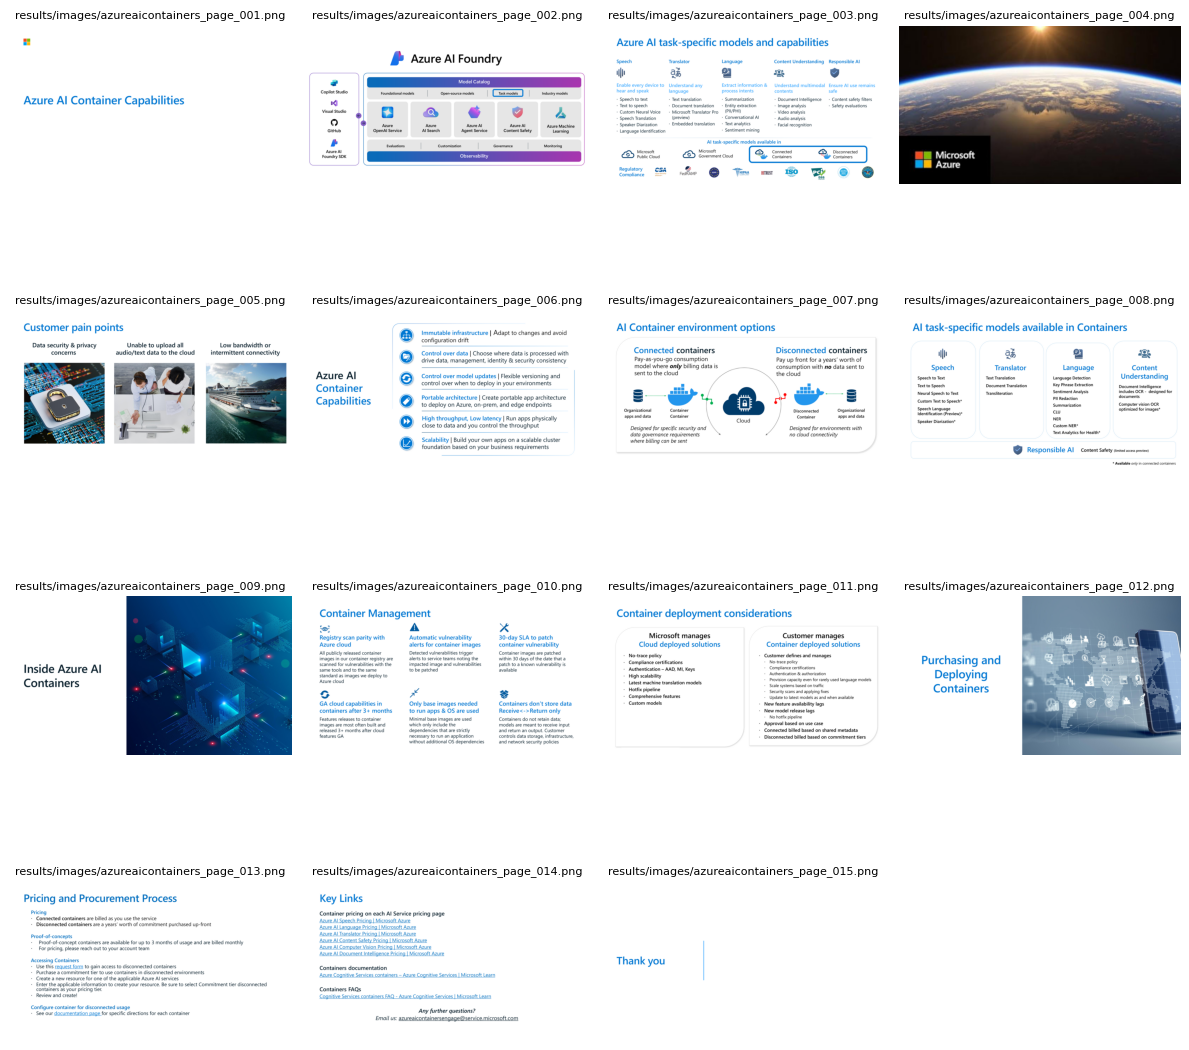

In [19]:
n_cols = 4
n_rows = (len(png_files) + n_cols - 1) // n_cols

plt.figure(figsize=(12, n_rows * 3))

for idx, image_path in enumerate(png_files):
    img = Image.open(image_path).convert("RGB")
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(img)
    plt.title(image_path, fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()

## 4. Text generation for each page

In [20]:
start = time.time()

data = []

prompt = """
Summarize the core message in 2 or 3 sentences. Be precise and sharp. Adopt a neutral style.

Examples:
- This slide introduces Azure AI Container Capabilities. It focuses on how Azure AI services can be deployed and managed in containerized environments.
- This page is to introduce now Azure AI Foundry, a platform offering a comprehensive suite of AI services, including foundational and task-specific models like Azure OpenAI Service, AI Search, and Machine Learning. It integrates tools like Copilot Studio, Visual Studio, and GitHub for development, with features for evaluation, customization, governance, and monitoring to ensure robust and secure AI deployment.
- Now this is about Azure can leverages artificial intelligence to enable innovative solutions and drive global impact.
"""

print("Running GenAI on each page to get the transcript\n")

for idx, image_file in enumerate(png_files):
    print(f"✅ Running analysis from page {idx+1:003}")
    result = model_calling(local_image(image_file), prompt)
    text = result.choices[0].message.content
    data.append({
        "idx": idx + 1,
        "image_page_file": png_files[idx],
        "text": text
    })

minutes, seconds = divmod((time.time() - start), 60)
print(f"\nElapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Running GenAI on each page to get the transcript

✅ Running analysis from page 001
✅ Running analysis from page 002
✅ Running analysis from page 003
✅ Running analysis from page 004
✅ Running analysis from page 005
✅ Running analysis from page 006
✅ Running analysis from page 007
✅ Running analysis from page 008
✅ Running analysis from page 009
✅ Running analysis from page 010
✅ Running analysis from page 011
✅ Running analysis from page 012
✅ Running analysis from page 013
✅ Running analysis from page 014
✅ Running analysis from page 015

Elapsed time = 0 minutes and 37 seconds


In [21]:
df = pd.DataFrame(data)
df

idx                                image_page_file  \
0     1  results/images/azureaicontainers_page_001.png   
1     2  results/images/azureaicontainers_page_002.png   
2     3  results/images/azureaicontainers_page_003.png   
3     4  results/images/azureaicontainers_page_004.png   
4     5  results/images/azureaicontainers_page_005.png   
5     6  results/images/azureaicontainers_page_006.png   
6     7  results/images/azureaicontainers_page_007.png   
7     8  results/images/azureaicontainers_page_008.png   
8     9  results/images/azureaicontainers_page_009.png   
9    10  results/images/azureaicontainers_page_010.png   
10   11  results/images/azureaicontainers_page_011.png   
11   12  results/images/azureaicontainers_page_012.png   
12   13  results/images/azureaicontainers_page_013.png   
13   14  results/images/azureaicontainers_page_014.png   
14   15  results/images/azureaicontainers_page_015.png   

                                                 text  
0   This slide introduces Azure AI Container Capab...  
1   This slide presents Azure AI Foundry as a unif...  
2   This slide outlines Azure AI's task-specific m...  
3   This image highlights Microsoft Azure’s global...  
4   This slide highlights key customer challenges ...  
5   This slide outlines the key capabilities of Az...  
6   This slide presents two AI container deploymen...  
7   This slide presents the range of AI task-speci...  
8   This slide introduces the concept of Azure AI ...  
9   This slide outlines Azure's approach to contai...  
10  This slide compares cloud-deployed solutions m...  
11  This slide introduces the process of purchasin...  
12  This slide outlines the pricing and procuremen...  
13  This page provides key links to container pric...  
14  This slide serves as a closing statement, expr...

In [22]:
print("\033[1;31;34m")

for idx in range(len(df)):
    print(f"📄 Slide {idx + 1}: {df.iloc[idx, 1]}\n")
    print(df.iloc[idx, 2])
    print("➖" * 60, "\n")


📄 Slide 1: results/images/azureaicontainers_page_001.png

This slide introduces Azure AI Container Capabilities. It highlights how Azure AI services can be deployed and managed within containerized environments.
➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖ 

📄 Slide 2: results/images/azureaicontainers_page_002.png

This slide presents Azure AI Foundry as a unified platform that offers a catalog of foundational, open-source, task, and industry AI models, integrated with core services like OpenAI, AI Search, Agent Service, Content Safety, and Machine Learning. It highlights seamless development through tools such as Copilot Studio, Visual Studio, GitHub, and the Azure AI Foundry SDK, while emphasizing capabilities for evaluation, customization, governance, monitoring, and observability.
➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖ 

📄 Slide 3: results/images/azureaicontainers_page_003.png

This slide outlines Azure AI's task-specific models and capabiliti

## 5. Text to Speech on each extracted page

In [23]:
start = time.time()

speech_config = speechsdk.SpeechConfig(subscription=speech_key,
                                       region=service_region)

speech_config.speech_synthesis_voice_name = "en-US-Andrew2:DragonHDLatestNeural"
speech_config.set_speech_synthesis_output_format(speechsdk.SpeechSynthesisOutputFormat.Riff48Khz16BitMonoPcm)

print("Running Text to Speech on each page\n")

for index, row in df.iterrows():
    filename = os.path.join(
        AUDIO_DIR,
        os.path.basename(row["image_page_file"].replace(".png", ".wav"))
    )
    
    text = row["text"]
    audio_config = speechsdk.audio.AudioOutputConfig(filename=filename)
    synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config,
                                              audio_config=audio_config)
    result = synthesizer.speak_text_async(text).get()

    if result.reason == speechsdk.ResultReason.SynthesizingAudioCompleted:
        print(f"✅ Audio saved to {filename}")
    else:
        print(f"❌ Error synthesizing {filename}: {result.cancellation_details.reason}")

minutes, seconds = divmod((time.time() - start), 60)
print(f"\nElapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Running Text to Speech on each page

✅ Audio saved to results/audio/azureaicontainers_page_001.wav
✅ Audio saved to results/audio/azureaicontainers_page_002.wav
✅ Audio saved to results/audio/azureaicontainers_page_003.wav
✅ Audio saved to results/audio/azureaicontainers_page_004.wav
✅ Audio saved to results/audio/azureaicontainers_page_005.wav
✅ Audio saved to results/audio/azureaicontainers_page_006.wav
✅ Audio saved to results/audio/azureaicontainers_page_007.wav
✅ Audio saved to results/audio/azureaicontainers_page_008.wav
✅ Audio saved to results/audio/azureaicontainers_page_009.wav
✅ Audio saved to results/audio/azureaicontainers_page_010.wav
✅ Audio saved to results/audio/azureaicontainers_page_011.wav
✅ Audio saved to results/audio/azureaicontainers_page_012.wav
✅ Audio saved to results/audio/azureaicontainers_page_013.wav
✅ Audio saved to results/audio/azureaicontainers_page_014.wav
✅ Audio saved to results/audio/azureaicontainers_page_015.wav

Elapsed time = 1 minutes and 1 s

In [24]:
!ls $AUDIO_DIR/*.wav -lh

-rwxrwxrwx 1 root root  905K Jul 22 15:33 results/audio/azureaicontainers_page_001.wav
-rwxrwxrwx 1 root root  3.1M Jul 22 15:33 results/audio/azureaicontainers_page_002.wav
-rwxrwxrwx 1 root root  2.5M Jul 22 15:33 results/audio/azureaicontainers_page_003.wav
-rwxrwxrwx 1 root root  886K Jul 22 15:33 results/audio/azureaicontainers_page_004.wav
-rwxrwxrwx 1 root root  1.9M Jul 22 15:33 results/audio/azureaicontainers_page_005.wav
-rwxrwxrwx 1 root root  2.1M Jul 22 15:34 results/audio/azureaicontainers_page_006.wav
-rwxrwxrwx 1 root root  1.9M Jul 22 15:34 results/audio/azureaicontainers_page_007.wav
-rwxrwxrwx 1 root root  2.4M Jul 22 15:34 results/audio/azureaicontainers_page_008.wav
-rwxrwxrwx 1 root root  1.2M Jul 22 15:34 results/audio/azureaicontainers_page_009.wav
-rwxrwxrwx 1 root root  2.4M Jul 22 15:34 results/audio/azureaicontainers_page_010.wav
-rwxrwxrwx 1 root root  2.1M Jul 22 15:34 results/audio/azureaicontainers_page_011.wav
-rwxrwxrwx 1 root root 1013K Jul 22 15:34 r

In [25]:
wav_files = glob.glob(os.path.join(AUDIO_DIR, '**/*.wav'), recursive=True)

## 6. Video generation for each page

In [26]:
start = time.time()

# Sort the lists to be sure
png_files.sort()
wav_files.sort()

print("Generating video clip for each page\n")

for idx in range(len(png_files)):
    image_clip = ImageClip(png_files[idx])
    audio_clip = AudioFileClip(wav_files[idx])
    video_clip = image_clip.with_duration(audio_clip.duration)
    new_audioclip = CompositeAudioClip([audio_clip])
    video_clip.audio = new_audioclip
    
    # Output filename
    output_video = os.path.join(
        VIDEO_DIR,
        f"{os.path.splitext(os.path.basename(pdf_document))[0]}_video_{idx+1:03}.mp4").replace(" ", "_")
    
    # Saving the clip
    video_clip.write_videofile(
        output_video,
        fps=1,
        codec="libx264",
        audio_codec="aac",
        logger=None,
    )
    print(f"✅ Video saved to {output_video}")

minutes, seconds = divmod((time.time() - start), 60)
print(f"\nElapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Generating video clip for each page

✅ Video saved to results/video/azureaicontainers_video_001.mp4
✅ Video saved to results/video/azureaicontainers_video_002.mp4
✅ Video saved to results/video/azureaicontainers_video_003.mp4
✅ Video saved to results/video/azureaicontainers_video_004.mp4
✅ Video saved to results/video/azureaicontainers_video_005.mp4
✅ Video saved to results/video/azureaicontainers_video_006.mp4
✅ Video saved to results/video/azureaicontainers_video_007.mp4
✅ Video saved to results/video/azureaicontainers_video_008.mp4
✅ Video saved to results/video/azureaicontainers_video_009.mp4
✅ Video saved to results/video/azureaicontainers_video_010.mp4
✅ Video saved to results/video/azureaicontainers_video_011.mp4
✅ Video saved to results/video/azureaicontainers_video_012.mp4
✅ Video saved to results/video/azureaicontainers_video_013.mp4
✅ Video saved to results/video/azureaicontainers_video_014.mp4
✅ Video saved to results/video/azureaicontainers_video_015.mp4

Elapsed time = 0 

In [27]:
video_files = glob.glob(os.path.join(VIDEO_DIR, "**/*.mp4"), recursive=True)

In [28]:
!ls $VIDEO_DIR/*.mp4 -lh

-rwxrwxrwx 1 root root 165K Jul 22 15:34 results/video/azureaicontainers_video_001.mp4
-rwxrwxrwx 1 root root 574K Jul 22 15:34 results/video/azureaicontainers_video_002.mp4
-rwxrwxrwx 1 root root 545K Jul 22 15:34 results/video/azureaicontainers_video_003.mp4
-rwxrwxrwx 1 root root 221K Jul 22 15:34 results/video/azureaicontainers_video_004.mp4
-rwxrwxrwx 1 root root 463K Jul 22 15:34 results/video/azureaicontainers_video_005.mp4
-rwxrwxrwx 1 root root 453K Jul 22 15:34 results/video/azureaicontainers_video_006.mp4
-rwxrwxrwx 1 root root 386K Jul 22 15:34 results/video/azureaicontainers_video_007.mp4
-rwxrwxrwx 1 root root 481K Jul 22 15:34 results/video/azureaicontainers_video_008.mp4
-rwxrwxrwx 1 root root 325K Jul 22 15:34 results/video/azureaicontainers_video_009.mp4
-rwxrwxrwx 1 root root 533K Jul 22 15:35 results/video/azureaicontainers_video_010.mp4
-rwxrwxrwx 1 root root 428K Jul 22 15:35 results/video/azureaicontainers_video_011.mp4
-rwxrwxrwx 1 root root 262K Jul 22 15:35 re

## 7. Final video file

In [29]:
start = time.time()
print("Generating the final video file\n")

final_video_file = os.path.join(
    FINAL_VIDEO_DIR,
    f"{os.path.splitext(os.path.basename(pdf_document))[0]}_video.mp4").replace(" ", "_")

# Loading clips with simple progress
print(f"Loading {len(video_files)} video clips...\n")

clips_list = []
for i, video_file in enumerate(video_files):
    clip = VideoFileClip(video_file)
    clips_list.append(clip)
    progress = (i + 1) / len(video_files) * 100
    print(f"\rLoading clips: {progress:.1f}% ({i+1}/{len(video_files)})", end="", flush=True)

final_video = concatenate_videoclips(clips_list)

final_video.write_videofile(
    final_video_file,
)

for i, clip in enumerate(clips_list):
    clip.close()
final_video.close()

print(f"\n✅ Complete!")
minutes, seconds = divmod((time.time() - start), 60)
print(f"\nElapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Generating the final video file

Loading 15 video clips...

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1024, 576], 'bitrate': 10, 'fps': 1.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 126, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 9.65, 'bitrate': 139, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': 

MoviePy - Done.
MoviePy - Writing video video/azureaicontainers_video.mp4



frame_index:   0%|          | 0/283 [00:00<?, ?it/s, now=None]/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/moviepy/video/io/ffmpeg_reader.py:178: UserWarning: In file results/video/azureaicontainers_video_001.mp4, 1769472 bytes wanted but 0 bytes read at frame index 9 (out of a total 9 frames), at time 9.00/9.65 sec. Using the last valid frame instead.
  warnings.warn(
frame_index:  15%|█▍        | 42/283 [00:00<00:01, 218.67it/s, now=None]/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/moviepy/video/io/ffmpeg_reader.py:178: UserWarning: In file results/video/azureaicontainers_video_002.mp4, 1769472 bytes wanted but 0 bytes read at frame index 33 (out of a total 33 frames), at time 33.00/33.50 sec. Using the last valid frame instead.
  warnings.warn(
frame_index:  32%|███▏      | 91/283 [00:00<00:00, 230.99it/s, now=None]/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/moviepy/video/io/ffmpeg_reader.py:178: UserWarning: In file results/

MoviePy - Done !
MoviePy - video ready video/azureaicontainers_video.mp4

✅ Complete!

Elapsed time = 0 minutes and 14 seconds


In [30]:
clip = VideoFileClip(final_video_file)

{'video_found': True, 'audio_found': True, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.1.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [1024, 576], 'bitrate': 40, 'fps': 1.0, 'codec_name': 'h264', 'profile': '(High)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.3.100 libx264'}}, {'input_number': 0, 'stream_number': 1, 'stream_type': 'audio', 'language': None, 'default': True, 'fps': 44100, 'bitrate': 127, 'metadata': {'Metadata': '', 'handler_name': 'SoundHandler', 'vendor_id': '[0][0][0][0]'}}], 'input_number': 0}], 'duration': 283.33, 'bitrate': 170, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High)', 'video_size': [1024, 576], 'video_bitrate': 40, 'video_fps': 1.0, 'defau

In [31]:
fps = int(clip.fps)
duration = clip.duration
mins = int(duration // 60)
secs = int(duration % 60)
resolution = clip.size
audio = clip.audio
audio_channels = audio.nchannels if audio else 0
num_frames = int(fps * duration)

# Display results
!ls $final_video_file -lh

print(f"Duration: {mins} minutes and {secs} seconds")
print(f"Frames per second (FPS): {fps}")
print(f"Resolution (w x h): {resolution}")
print(f"Audio Channels: {audio_channels}")
print(f"Total Frames: {num_frames}")

-rwxrwxrwx 1 root root 5.8M Jul 22 15:35 video/azureaicontainers_video.mp4
Duration: 4 minutes and 43 seconds
Frames per second (FPS): 1
Resolution (w x h): [1024, 576]
Audio Channels: 2
Total Frames: 283


In [32]:
Video(final_video_file, embed=True)

In [33]:
video_link = FileLink(path=final_video_file)
video_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/from pptx to video/video/azureaicontainers_video.mp4